# Silent Substitution by spectral compensation method
#### v2.1 | by M. Zimmermann

This script detailed a silent substitution protocol for generating opsin-isolating stimuli that account for the cross-activation of zebrafish opsins by the LEDs. 

"When two lights with physically different spectral distributions form a complete visual match (metamers), they are exactly equal for the all cone pigments and, therefore, completely interchangeable for the visual system. If one of these two lights was substituted for the other, the visual system would not be able to detect the change. (Estévez and Spekreijse, 1982) "

Here, one opsin type is selectively stimulated by presenting a scaled, counterphase version of the stimulus to all other opsin types. 

***

In [1]:
import os
import glob
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.special as sse
import pylab
from scipy.optimize import curve_fit
from IPython import display

# Helpers
#
import scripts.spectrum as spc
import scripts.progress_bar as pbar
import scripts.spectrometer_helper as spm
import scripts.fitting_funcs as fit

# Set graphics to be plotted in the notebook
#
%matplotlib inline 

# Seaborn plot settings
#
sns.set()

# Paths and file names
# (Don't change unless you know what you are doing)
#
path_LightSources   = "light-sources//"
path_Filters        = "filters//"
path_Data           = "data//"
path_Opsins         = "opsins//"
file_GammaLUT       = "defaultGammaLUT"

txtFileNewLineStr   = "\r\n"

def setPlotStyle():
    # Presettings for figures
    #
    mpl.rcParams['figure.figsize'] = [10, 5]
    mpl.rc('font', size=10)          
    mpl.rc('axes', titlesize=12)    
    mpl.rc('axes', labelsize=12)    
    mpl.rc('xtick', labelsize=12)   
    mpl.rc('ytick', labelsize=12)   
    mpl.rc('legend', fontsize=12)   
    mpl.rc('figure', titlesize=12) 

In [2]:
x_wavelen_nm      = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(4,)) # 300 .. 699 nm
zebrafishLOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(3,))
zebrafishMOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(2,))
zebrafishSOpsin   = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(1,))
zebrafishUVOpsin  = np.loadtxt(path_Opsins +"zebrafish_cone_opsins.txt", usecols=(0,))

In [3]:
LCone = {"name"           : "zebrafish_L_cone",
         "peak_nm"        : 565,
         "collecArea_um2" : [], 
         "spect"          : zebrafishLOpsin,}
MCone = {"name"           : "zebrafish_M_cone",
         "peak_nm"        : 482,
         "collecArea_um2" : [], 
         "spect"          : zebrafishMOpsin,}
SCone = {"name"           : "zebrafish_S_cone",
         "peak_nm"        : 411,         
         "collecArea_um2" : [], 
         "spect"          : zebrafishSOpsin,}
UVCone = {"name"           : "zebrafish_U_cone",
         "peak_nm"        : 361,
         "collecArea_um2" : [], 
         "spect"          : zebrafishUVOpsin,}
PRs   = [LCone, MCone, SCone, UVCone]

***

### We begin by writing in matrix notation the three linear relations between the stimuli r, g, b and uv and the total quantum catch produced in each of the cone pigments $S_{Cone/LED}$

### $$
\left(\begin{array}{cc} 
S_{Red}\\
S_{Green}\\
S_{Blue}\\
S_{UV}
\end{array}\right)
=
\left(\begin{array}{cc} 
S_{L/R} & S_{M/R} & S_{S/R} & S_{UV/R}\\
S_{L/G} & S_{M/G} & S_{S/G} & S_{UV/G}\\
S_{L/B} & S_{M/B} & S_{S/B} & S_{UV/B}\\
S_{L/UV} & S_{M/UV} & S_{S/UV} & S_{UV/UV}
\end{array}\right)
x
\left(\begin{array}{cc} 
r\\
g\\
b\\
uv
\end{array}\right)
$$ 

#### Let's write the above equation in abbreviated form:
### $$
\left(\begin{array}{cc} 
S
\end{array}\right)
=
\left(\begin{array}{cc} 
M
\end{array}\right)
x
\left(\begin{array}{cc} 
C
\end{array}\right)
$$ 
#### Where:

#### S, the effective cone stimuli

#### M, the transform matrix

#### C, the colour mixture columns vector

#### If we call N the inverse matrix of M, then:
### $$
\left(\begin{array}{cc} 
C
\end{array}\right)
=
\left(\begin{array}{cc} 
N
\end{array}\right)
x
\left(\begin{array}{cc} 
S
\end{array}\right)
$$ 

### We notice that, within the limits imposed by the transformation M, one can choose to stimulate the four cone systems in some ratio by finding the corresponding values of r, g, b,uv solving the above equation. 

***

# First we generate the M Matrix from the photoisomerisation rate matrix 
(cf. `stimulator_calibration.ipynb`)

## Photoisomerisation rate =  $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


***

### Determining the Light Collection Area of cone outer segments

 ### $A_{collect} = OSA . \gamma . 1-10^{\alpha . OSL}$ 

With

OSA the Outer Segment Area (in µm$^{2}$)

$\gamma$ the quantum efficiency of the opsin change

$\alpha$ the cone specific absorption coefficient (in µm$^{-1}$)

OSL the Outer Segment Length (in µm)


In [4]:
# Outer Segment Diameter for R,G,B & UV cones in µm. 
# Allison et al. 2004 - Visual pigment composition in zebrafish
OSD = np.asarray([2.4, 2.4, 2.8, 2.6], dtype = np.float64) 

# Outer Segment Area
OSA = np.pi*(OSD[:]/2)**2

# Outer Segment Length in µm 
# Branchek et al. 1984 - The development of photoreceptors in the zebrafish, Brachydanio rerio. I. Structure 
OSL = [10, 10, 7.6, 10]

# Specific Absorbance for R,G,B & UV opsins in µm-1
# Allison et al. 2004 - Visual pigment composition in zebrafish
Alpha = [0.0073, 0.0063, 0.007, 0.0054] 

# Quantum efficiency of the opsin change (p(Photoisomerisation/Light being absorbed)) 
# Dartnall et al. 1967 - The photosensitivities of visual pigments in the presence of hydroxylamine
Gamma = 0.67

#### Determine the Specific Absorption Coefficient $1-10^{\alpha . OSL}$ 

Also known as the Specific Optical Density, it is defined as the fraction of light absorbed per infinitesimal unit length of photopigment. It depends only on the absorption properties of the photopigment.

In [5]:
Absorption_coef = np.zeros((4))
for iCone in range (4):
    Absorption_coef[iCone] = 1-(10**(-Alpha[iCone]*OSL[iCone]))

#### Calculate the Light Collection Area $A_{collect}$ = OSA . $\gamma$ . Absorption Coefficient 

In [6]:
A_Collect = np.zeros((4))
for iCone in range (4):
    A_Collect[iCone] = OSA[iCone] * Gamma * Absorption_coef[iCone]
print('Red Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[0],decimals=2)) +' µm²'  '\033[0m')
print('Green Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[1],decimals=2)) +' µm²'  '\033[0m')
print('Blue Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[2],decimals=2)) +' µm²'  '\033[0m')
print('UV Photoreceptor Light Collection Area = ' '\033[1m''\033[4m'+ str(np.around(A_Collect[3],decimals=2)) +' µm²'  '\033[0m')

Red Photoreceptor Light Collection Area = 0.47 µm²
Green Photoreceptor Light Collection Area = 0.41 µm²
Blue Photoreceptor Light Collection Area = 0.48 µm²
UV Photoreceptor Light Collection Area = 0.42 µm²


***

### Determining the Light Collection Area of cone outer segments
For the following protocol we will consider $P_{E}(\lambda)$ = 1 $photon . s^{-1} . µm^{-2}$

In [7]:
P_E = np.ones((4,4))
P_E

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

***

### Now we can determine the single Photon Flux for each LED on each Opsin

#### $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$    (in $photons . s^{-1}$)

In [8]:
R_Ph = np.zeros((4,4))
for iCone in range(4):
    for iLED in range(4):
        R_Ph[iLED,iCone] = P_E[iCone,iLED]*A_Collect[iCone]
R_Ph

array([[0.46896115, 0.4092834 , 0.47564131, 0.41591114],
       [0.46896115, 0.4092834 , 0.47564131, 0.41591114],
       [0.46896115, 0.4092834 , 0.47564131, 0.41591114],
       [0.46896115, 0.4092834 , 0.47564131, 0.41591114]])

***

### Determining the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$
(cf. `stimulator_calibration.ipynb`)

In [9]:
S_act = np.loadtxt("relative_coexcitation.txt")

S_Act = np.zeros((4,4))
for iLED in range(4):
    for iCone in range(4):
        S_Act[iLED,iCone] = S_act[iLED*4+iCone]
S_Act

array([[0.89898905, 0.02478379, 0.01162787, 0.00490286],
       [0.31003315, 0.96000473, 0.07470311, 0.00306961],
       [0.17106694, 0.47820079, 0.87155057, 0.01989093],
       [0.26811171, 0.24563629, 0.64932937, 0.816834  ]])

***

### Finally, we determine the M Matrix = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$
Values are in $photons . s^{-1}$

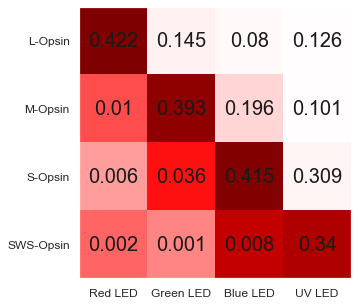

In [10]:
M_Matrix = np.zeros((4,4))

setPlotStyle()
fig, ax = plt.subplots()
im = ax.imshow(M_Matrix)

for iLED in range(4):
    for iCone in range(4):
        M_Matrix[iLED,iCone] = R_Ph[iLED,iCone] * S_Act[iLED,iCone]
        
     
ax.imshow(M_Matrix, cmap = 'seismic', vmin = -np.amax(np.abs(M_Matrix)), vmax = np.amax(np.abs(M_Matrix)))    
for iLED in range(4):
    for iCone in range(4):
        text = ax.text(iLED, iCone, np.around(M_Matrix[iLED, iCone],decimals=3),ha="center", va="center", size =20, color="k")
        
ax.grid(False)
Cones = ["L-Opsin", "M-Opsin", "S-Opsin", "SWS-Opsin"]
LEDs = ["Red LED", "Green LED", "Blue LED","UV LED"]

ax.set_xticks(np.arange(len(LEDs)))
ax.set_yticks(np.arange(len(Cones)))
ax.set_xticklabels(LEDs)
ax.set_yticklabels(Cones)
ax.set_ylim([3.5,-0.5])

plt.show()

### Now we generate the N Matrix ($M^{-1}$)

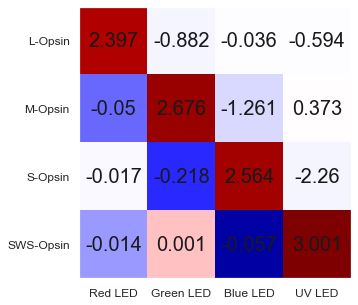

In [11]:
N_Matrix = np.linalg.inv(M_Matrix)

fig, ax = plt.subplots()
im = ax.imshow(N_Matrix)

ax.imshow(N_Matrix, cmap = 'seismic', vmin = -np.amax(np.abs(N_Matrix)), vmax = np.amax(np.abs(N_Matrix)))
for iLED in range(4):
    for iCone in range(4):
        text = ax.text(iLED, iCone, np.around(N_Matrix[iLED, iCone],decimals=3),ha="center", va="center", size =20, color="k")

ax.grid(False)
ax.set_xticks(np.arange(len(LEDs)))
ax.set_yticks(np.arange(len(Cones)))
ax.set_xticklabels(LEDs)
ax.set_yticklabels(Cones)
ax.set_ylim([3.5,-0.5])

plt.show()

***

### Now that we have the N Matrix for our system, we need to determine the effective cone stimuli (S)

Finally, we generate a normalised stimuli that the isolated opsin will be stimulated with (here a sine wave as example):
The other expected opsin response will be set to 0.5

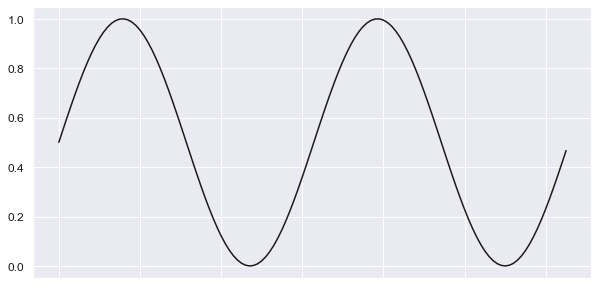

In [12]:
X_Stimulus = np.arange(0, 4*np.pi, 0.1)
A_Stimulus = (np.sin(X_Stimulus)+1)/2
plt.plot(X_Stimulus,A_Stimulus,'k')
plt.xticks(color='w')
plt.yticks(color='k');

***

## Isolating the L Cone

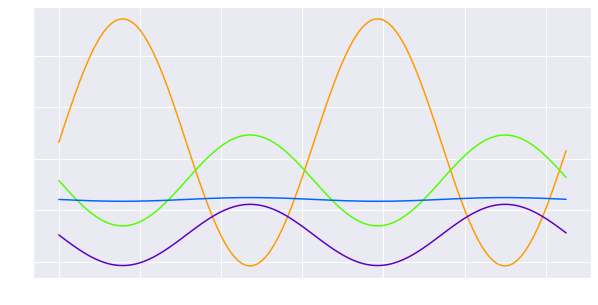

In [13]:
L_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    L_ratio = np.zeros((4))
    L_ratio[0] = vals[i]
    L_ratio[1] = 0.5
    L_ratio[2] = 0.5
    L_ratio[3] = 0.5
    L_Cone_isolation.append(L_ratio)
    
L_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = N_Matrix@L_Cone_isolation[i]
    L_LED_ratios.append(LED)
    
L_LED_ratios = np.stack(L_LED_ratios)

colours = []
for PR in PRs:
    if len(PR["spect"]) > 0:
        colour=spc.wavelength_to_rgb(PR["peak_nm"])
    colours.append(colour)
    
plt.plot(X_Stimulus,L_LED_ratios[:,0],color=colours[0])
plt.plot(X_Stimulus,L_LED_ratios[:,1],color=colours[1])
plt.plot(X_Stimulus,L_LED_ratios[:,2],color=colours[2])
plt.plot(X_Stimulus,L_LED_ratios[:,3],color=colours[3])
plt.xticks(color='w')
plt.yticks(color='w');

***

### Isolating the M Cone

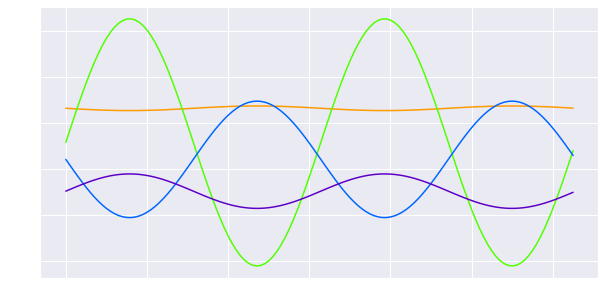

In [14]:
M_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    M_ratio = np.zeros((4))
    M_ratio[0] = 0.5
    M_ratio[1] = vals[i]
    M_ratio[2] = 0.5
    M_ratio[3] = 0.5
    M_Cone_isolation.append(M_ratio)
    
M_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = N_Matrix@M_Cone_isolation[i]
    M_LED_ratios.append(LED)
    
M_LED_ratios = np.stack(M_LED_ratios)

plt.plot(X_Stimulus,M_LED_ratios[:,0],color=colours[0])
plt.plot(X_Stimulus,M_LED_ratios[:,1],color=colours[1])
plt.plot(X_Stimulus,M_LED_ratios[:,2],color=colours[2])
plt.plot(X_Stimulus,M_LED_ratios[:,3],color=colours[3])
plt.xticks(color='w')
plt.yticks(color='w');

***

### Isolating the S Cone

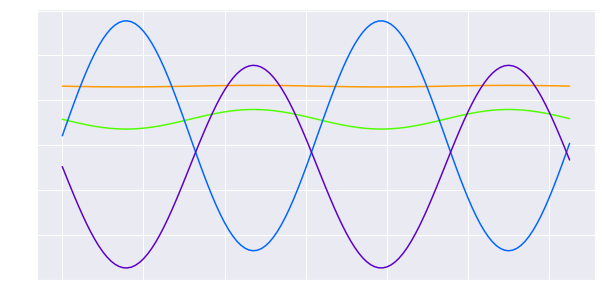

In [15]:
S_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    S_ratio = np.zeros((4))
    S_ratio[0] = 0.5
    S_ratio[1] = 0.5
    S_ratio[2] = vals[i]
    S_ratio[3] = 0.5
    S_Cone_isolation.append(S_ratio*10)
    
S_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = N_Matrix@S_Cone_isolation[i]
    S_LED_ratios.append(LED)
    
S_LED_ratios = np.stack(S_LED_ratios)

plt.plot(X_Stimulus,S_LED_ratios[:,0],color=colours[0])
plt.plot(X_Stimulus,S_LED_ratios[:,1],color=colours[1])
plt.plot(X_Stimulus,S_LED_ratios[:,2],color=colours[2])
plt.plot(X_Stimulus,S_LED_ratios[:,3],color=colours[3])
plt.xticks(color='w')
plt.yticks(color='w');

***

### Isolating the UV Cone

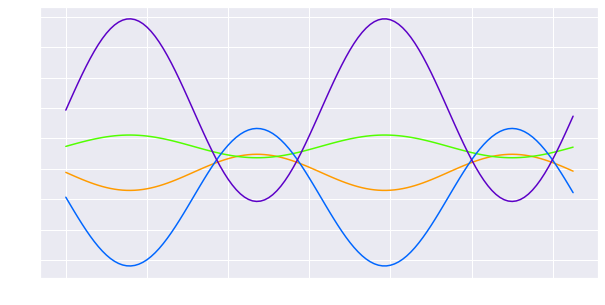

In [16]:
UV_Cone_isolation = []
vals = A_Stimulus
for i in range(len(A_Stimulus)): 
    UV_ratio = np.zeros((4))
    UV_ratio[0] = 0.5
    UV_ratio[1] = 0.5
    UV_ratio[2] = 0.5
    UV_ratio[3] = vals[i]
    UV_Cone_isolation.append(UV_ratio)
    
UV_LED_ratios = []
for i in range(len(A_Stimulus)):
    LED = UV_Cone_isolation[i]@N_Matrix
    UV_LED_ratios.append(LED)
    
UV_LED_ratios = np.stack(UV_LED_ratios)

plt.plot(X_Stimulus,UV_LED_ratios[:,0],color=colours[0])
plt.plot(X_Stimulus,UV_LED_ratios[:,1],color=colours[1])
plt.plot(X_Stimulus,UV_LED_ratios[:,2],color=colours[2])
plt.plot(X_Stimulus,UV_LED_ratios[:,3],color=colours[3])
plt.xticks(color='w')
plt.yticks(color='w');